# Population-weighted heating degree days

*Heating degree days* (HDD) provide a simple measure of energy use. The assumption is that people start heating their homes once temperatures drop below a certain threshold. By counting the number of such days one can anticipate energy use.

The notebook `hdd.ipynb` showed how to calculate heating degree days for different threshold values. We now build upon this by weighing the heating degree days by population density. The rationale for this is quite simple -- low temperatures do not matter if nobody is around to feel the cold.

The population density comes from layer `48774`. Consult the data explorer (https://ibmpairs.mybluemix.net/data-explorer) for more details. For background on the weather forecast data we will be using here consult the notebook `hdd.ipynb`.

**Note** this showcases one of the core features of PAIRS. The weather forecast and population data are very different datasets from different data providers at different spatial resolution. However, in the context of this notebook they are handled as essentially the same.

In [1]:
from datetime import datetime, timedelta
import re, os, pandas as pd, numpy as np, logging
from matplotlib import colors, pyplot as plt
from ibmpairs import paw, authentication

We set some auxiliary variables and configure the logging system. E.g. `iso8601` helps when converting datetime objects to strings in ISO 8601-compliant format.

In [2]:
oneSec = timedelta(seconds=1)
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

logging.basicConfig(level=logging.WARNING)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.ERROR)

We use our API key to authenticate. To do so, we generate an authentication object `pairs_credentials`. When using the `paw` library, this can be used directly when instantiating a query via `paw.PAIRSQuery`. However, when submitting an API request directly (via e.g. python's `requests` module), we need to use a suitable HTTP header. We construct this directly as well. See `pairs_auth_headers`.

**Please replace `<YOUR-PAIRS-API-KEY>` with your PAIRS API key.**

In [3]:
pairs_api_key = '<YOUR-PAIRS-API-KEY>'

Specifically, we use `authentication.OAuth2` to retrieve the access token:

In [4]:
pairs_credentials = authentication.OAuth2(api_key=pairs_api_key)
pairs_auth_headers={
    'authorization' : f'Bearer {pairs_credentials.jwt_token}',
    'content-type' : 'application/json'
}

The token will expire after an hour. This notebook will run in less time, so this is no issue. For longer running jobs use `pairs_credentials.refresh_auth_token()` to refresh. See https://pairs.res.ibm.com/tutorial/tutorials/api/paw.html#refreshing-a-token for details.


## Step 1: Run a point query

When working with PAIRS, it is generally good practice to start with a point query. Point queries are fast and create immediate responses, allowing users to ensure that they understand the data they are accessing. In this case we are interested in layer `48774`.

In [5]:
pointQueryJson = {
    'layers' : [
        {
            'type' : 'raster', 'id' : '48774',
        }
    ],
    'spatial' : {'type' : 'point', 'coordinates' : ['40', '-100']},
    'temporal' : {'intervals' : [{'start' : datetime(2000, 10, 1).strftime(iso8601), 'end' : datetime(2019, 12, 1).strftime(iso8601)}]}
}

In [6]:
pointQuery = paw.PAIRSQuery(pointQueryJson, auth=pairs_credentials, authType='api-key')

In [7]:
pointQuery.submit()
pointQuery.vdf

,layerId,timestamp,longitude,latitude,value,region,property,geometry
0,48774,2005-01-01 00:00:00+00:00,-100.0,40.0,0.139365,NaN,NaN,POINT (-100.00000 40.00000)
1,48774,2010-01-01 00:00:00+00:00,-100.0,40.0,0.139038,NaN,NaN,POINT (-100.00000 40.00000)
2,48774,2015-01-01 00:00:00+00:00,-100.0,40.0,0.137164,NaN,NaN,POINT (-100.00000 40.00000)


## Step 2: Calculate population weighted HDDs

The above point query informs us about the timestamps available for the population layer. We choose to work with the most recent one, 2015-01-01. Again we need yesterday's date to calculate the HDDs for the next two weeks.

In [9]:
utcToday = datetime.utcnow().replace(hour=0, minute=0, second=0, microsecond=0) - timedelta(days=1)

Again we use a function to calculate the HDDs for us. In the case at hand we add the population weights by a simple modification of the UDF.

In [10]:
def getQueryJson(today, threshold = 18, aggregate = False):
    queryJson = {
        'layers' : [
            {
                'alias' : 'L{0}DA{1}'.format(lID, str(daysAhead).zfill(2)),
                'aggregation' : 'Mean',
                'type' : 'raster', 'id' : lID,
                'dimensions' : [{'name' : 'issuetime', 'value' : '0'}, {'name' : 'horizon', 'value' : str(daysAhead + 1)}],
                'temporal' : {'intervals' : [{
                    'start' : (today + timedelta(days = daysAhead)).strftime(iso8601),
                    'end' : (today + timedelta(days = daysAhead)).strftime(iso8601)
                }]},
                'output' : False
            }
        for daysAhead in range(0, 16) for lID in ['49173', '49174']],
        'spatial' : {'type' : 'poly',  'aoi' : 24},
        'temporal' : {'intervals' : [{'snapshot' : today.strftime(iso8601)}]},
        #'publish' : False
    }
    if aggregate:
        queryJson['spatial'] = {
            'type' : 'square', 'coordinates' : [23, -125, 50, -67],
            'aggregation' : {
                'aoi': [i for i in range(121, 175)] # Conterminous USA state polygon IDs
            }
        }
    
    queryJson['layers'].extend([
        {
            'alias' : 'populationDensity', 'type' : 'raster', 'id' : '48774',
            'temporal' : {'intervals' : [{'snapshot' : datetime(2015, 1, 1).strftime(iso8601)}]},
            'output' : False
        },
        {
            'alias' : 'hdd{0}C'.format(threshold),
            'expression' : '+'.join([
                '(($L49173DA{0} + $L49174DA{0}) / 2 < {1} ? 1 : 0)'.format(str(daysAhead).zfill(2), format(threshold))
                for daysAhead in range(0, 16)
            ])
        },
        {
            'alias' : 'pwHDD{0}C'.format(threshold),
            'expression' : '$hdd{0}C * $populationDensity'.format(threshold)
        }
    ])
    return queryJson

In [11]:
queryJson = getQueryJson(utcToday, threshold = 18)

In [12]:
query = paw.PAIRSQuery(queryJson, auth=pairs_credentials, authType='api-key')
query.submit()

In [13]:
query.poll_till_finished()
query.download()
query.create_layers()

## Step 3: Results

The following shows both the raw as well the population-weighted heating degree days for a threshold of 18 degrees Celsius.

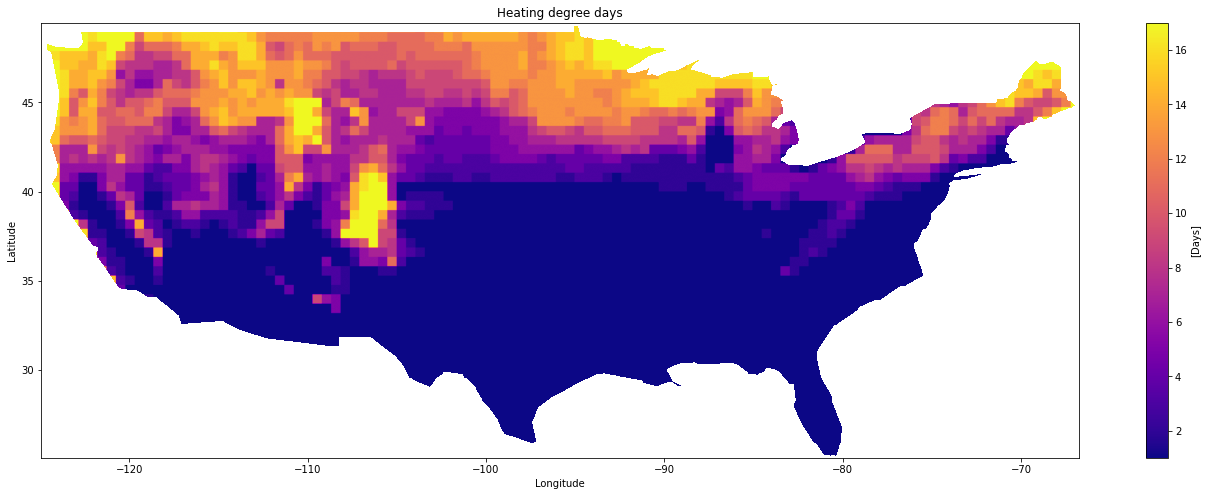

In [14]:
bBox = query.metadata['Expression-hdd18C[hdd18C]-Exp']['details']['boundingBox']

plt.figure(figsize = (24, 8))
plt.imshow(
    query.data['Expression-hdd18C[hdd18C]-Exp'] + 1, cmap = 'plasma',
    extent = [bBox['minLongitude'], bBox['maxLongitude'], bBox['minLatitude'], bBox['maxLatitude']]
)
plt.title('Heating degree days')
plt.colorbar(label = '[Days]')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.show()

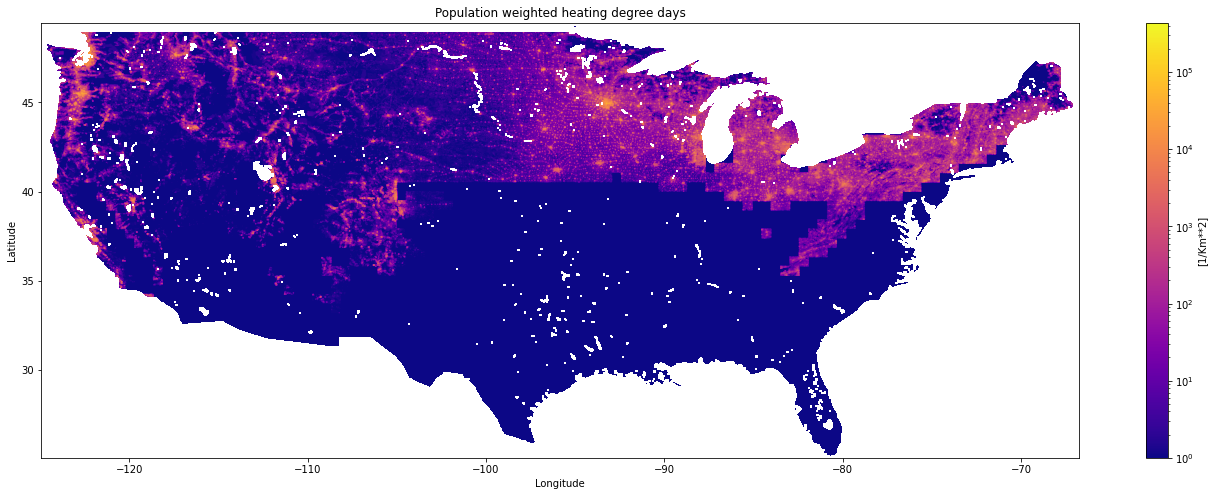

In [15]:
logNormalizer = colors.LogNorm(
    np.nanmin(query.data['Expression-pwHDD18C[pwHDD18C]-Exp']) + 1, np.nanmax(query.data['Expression-pwHDD18C[pwHDD18C]-Exp']) + 1
)

plt.figure(figsize = (24, 8))
plt.imshow(
    query.data['Expression-pwHDD18C[pwHDD18C]-Exp'] + 1, norm = logNormalizer, cmap = 'plasma',
    extent = [bBox['minLongitude'], bBox['maxLongitude'], bBox['minLatitude'], bBox['maxLatitude']]
)
plt.title('Population weighted heating degree days')
plt.colorbar(label = '[1/Km**2]')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.savefig('pwHDD.png', dpi = 60, bbox_inches = 'tight', transparent = False)
plt.show()